In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import scipy.stats as stats
from sklearn.metrics import brier_score_loss, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler

In [21]:
def get_return_dataframe(path,start_date,end_date):
    #（1）Import the required data and compute the true return
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    # Ensure the data is sorted by date
    df_filtered = df_filtered.sort_values('Date')
    
    # Calculate the 6-month return. The shift will be based on trading days (~126 trading days in 6 months)
    df_filtered['6m_return'] = df_filtered['Adj Close'].pct_change(periods = 126).shift(-126)
    
    df_return = df_filtered[['Date','6m_return']].dropna()
    df_return['log_6m_return'] = np.log(1+df_return['6m_return'])
    
    return df_return

In [22]:
# create a function to calculate the accuracy of the predictions
def calculate_prediction_accuracy(df, actual_col, p10_col, p50_col, p90_col):
    # Count how many times the actual log return falls within the p10 and p90 interval
    within_interval = df.apply(lambda row: row[p10_col] <= row[actual_col] <= row[p90_col], axis=1).sum()
    # Count how many times the actual log return is greater than the median prediction
    above_median = (df[actual_col] > df[p50_col]).sum()
    # Calculate the total number of points
    total_points = df.shape[0]
    
    # Calculate the accuracy percentages
    interval_accuracy = within_interval / total_points
    median_accuracy = above_median / total_points
    
    return {
        'within_interval_accuracy': interval_accuracy,
        'above_median_accuracy': median_accuracy,
        'total_points': total_points
    }


In [23]:
# Function to calculate z-score adjusted for skewness and kurtosis using Cornish-Fisher expansion
def z_score_cf_expansion(q, skew, kurt):
    # z is the z-score for the standard normal distribution
    z = stats.norm.ppf(q)
    
    # Cornish-Fisher expansion
    z_adj = z + (z**2 - 1) * skew / 6 + (z**3 - 3 * z) * (kurt - 3) / 24 - (2 * z**3 - 5 * z) * (skew**2) / 36
    return z_adj

In [24]:
def results_calculation(path,market,large_change_threshold,start_date,end_date):
    '''
    path: True data file path
    market: The str of the selected market. e.g. 'sp6m','bac'
    large_change_threshold: Value indicated in the mpd_stats
    start_date: Time used to start calculations
    end_date: Time used to the end of the calculation
    '''
    #（2）Take the market to be calculated, as the methodology document says it's all been collated into a forecast for 6 months out
    selected_market = mpd_stats_weekly[mpd_stats_weekly['market'] == market]
    market_return = get_return_dataframe(path,start_date,end_date)
    
    
    #（3）Comparing true return and predicted mean values
    # Based on the date in selected_market, take out the corresponding true return
    merged_data = pd.merge(selected_market,market_return,on = 'Date',how = 'left')
    merged_data.dropna()
    plt.figure(figsize=(14, 7))
    plt.plot(merged_data['Date'], merged_data['mu'], label=f'mu_{market}6m', color='blue')
    plt.plot(merged_data['Date'], merged_data['p50'], label=f'p50_{market}6m', color='orange')
    plt.plot(merged_data['Date'], merged_data['6m_return'], label='6m_change', color='green')

    plt.title(f'{market} Predicted vs Actual Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    
    #（4）Comparison of gaps by confidence intervals
    # Apply the 'calculate_prediction_accuracy' function to our merged data
    # Assuming the actual log returns column in merged_data is 'log_6m_return'
    accuracy_results_selected = calculate_prediction_accuracy(
        merged_data, 
        actual_col='log_6m_return', 
        p10_col='p10', 
        p50_col='p50', 
        p90_col='p90'
    )
    print(f'the accuracy of {market} predictions',accuracy_results_selected)
    
    
    #（5）Check whether can predict accuracy by directionality
    # Convert the 'log_6m_return' column to +1 if positive, -1 if negative
    market_return['log_6m_return_sign'] = market_return['log_6m_return'].apply(lambda x: 1 if x > 0 else -1)
    print(market_return)
    
    # Calculate the z-score for the 50th percentile (median)
    q_median = 0.5
    merged_data['z_median'] = z_score_cf_expansion(q_median, merged_data['skew'], merged_data['kurt'])

    # Calculate the adjusted probability of a positive return using the adjusted z-score for the 50th percentile
    merged_data['adj_prob_positive_return'] = 1 - stats.norm.cdf(merged_data['z_median'])

    # Display the new DataFrame with the calculated adjusted probabilities
    merged_data[['Date', 'mu', 'sd', 'skew', 'kurt', 'adj_prob_positive_return']]
    
    # Convert actual sign of return to binary (1 for positive, 0 for non-positive)
    market_return['actual_binary_outcome'] = market_return['log_6m_return_sign'].apply(lambda x: 1 if x == 1 else 0)
    
    # Merge the actual outcomes with the predicted probabilities
    eval_data = pd.merge(merged_data, market_return, on='Date')
    
    # Calculate Brier score
    brier_score = brier_score_loss(eval_data['actual_binary_outcome'], eval_data['adj_prob_positive_return'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(eval_data['actual_binary_outcome'], eval_data['adj_prob_positive_return'])
    roc_auc = auc(fpr, tpr)

    # Calculate Log Loss
    logloss = log_loss(eval_data['actual_binary_outcome'], eval_data['adj_prob_positive_return'])
    
    # Print the evaluation metrics
    print((brier_score, roc_auc, logloss))
    
    
    #（6）Judging the accuracy of predictions of large rises and falls
    market_return['large_increase'] = market_return['log_6m_return'].apply(lambda x: 1 if x >= large_change_threshold else 0)
    market_return['large_decrease'] = market_return['log_6m_return'].apply(lambda x: 1 if x <= -large_change_threshold else 0)
    
    # Using the large change threshold indicated by the mpd data (different market have different value)
    # 6m increase prediction scores
    eval_data = pd.merge(merged_data, market_return, on='Date')
    # Calculate Brier score
    brier_score_in = brier_score_loss(eval_data['large_increase'], eval_data['prInc'])

    # Calculate ROC curve and AUC
    fpr_in, tpr_in, thresholds_in = roc_curve(eval_data['large_increase'], eval_data['prInc'])
    roc_auc_in = auc(fpr_in, tpr_in)

    # Calculate Log Loss
    logloss_in = log_loss(eval_data['large_increase'], eval_data['prInc'])

    # Print the evaluation metrics
    print((brier_score_in, roc_auc_in, logloss_in))
    
    # 6m decrease prediction scores
    # Calculate Brier score
    brier_score_de = brier_score_loss(eval_data['large_decrease'], eval_data['prDec'])

    # Calculate ROC curve and AUC
    fpr_de, tpr_de, thresholds_de = roc_curve(eval_data['large_decrease'], eval_data['prDec'])
    roc_auc_de = auc(fpr_de, tpr_de)

    # Calculate Log Loss
    logloss_de = log_loss(eval_data['large_decrease'], eval_data['prDec'])

    # Print the evaluation metrics
    print((brier_score_de, roc_auc_de, logloss_de))

In [25]:
mpd_stats_weekly = pd.read_csv('mpd_stats_cleaned.csv')

In [26]:
mpd_stats_weekly['Date'] = pd.to_datetime(mpd_stats_weekly['Date'])

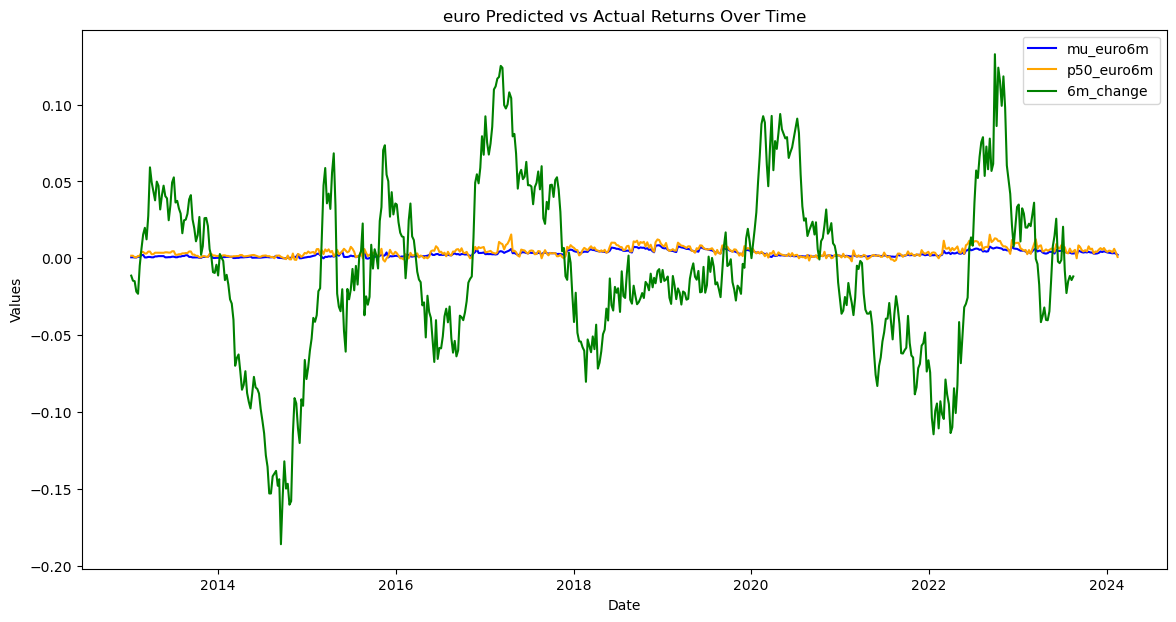

the accuracy of euro predictions {'within_interval_accuracy': 0.6424870466321243, 'above_median_accuracy': 0.3799654576856649, 'total_points': 579}
           Date  6m_return  log_6m_return  log_6m_return_sign
2378 2013-01-10  -0.011269      -0.011333                  -1
2379 2013-01-11  -0.033458      -0.034030                  -1
2380 2013-01-14  -0.036747      -0.037439                  -1
2381 2013-01-15  -0.044558      -0.045581                  -1
2382 2013-01-16  -0.009073      -0.009115                  -1
...         ...        ...            ...                 ...
5142 2023-08-16  -0.011777      -0.011847                  -1
5143 2023-08-17  -0.008977      -0.009017                  -1
5144 2023-08-18  -0.007030      -0.007055                  -1
5145 2023-08-21  -0.009501      -0.009547                  -1
5146 2023-08-22  -0.017381      -0.017533                  -1

[2769 rows x 4 columns]
(0.2482554785257998, 0.49533677363866047, 0.6896573775339812)
(0.019331368660869565

In [27]:
results_calculation(path = 'EURUSD=X.csv',market='euro',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14')

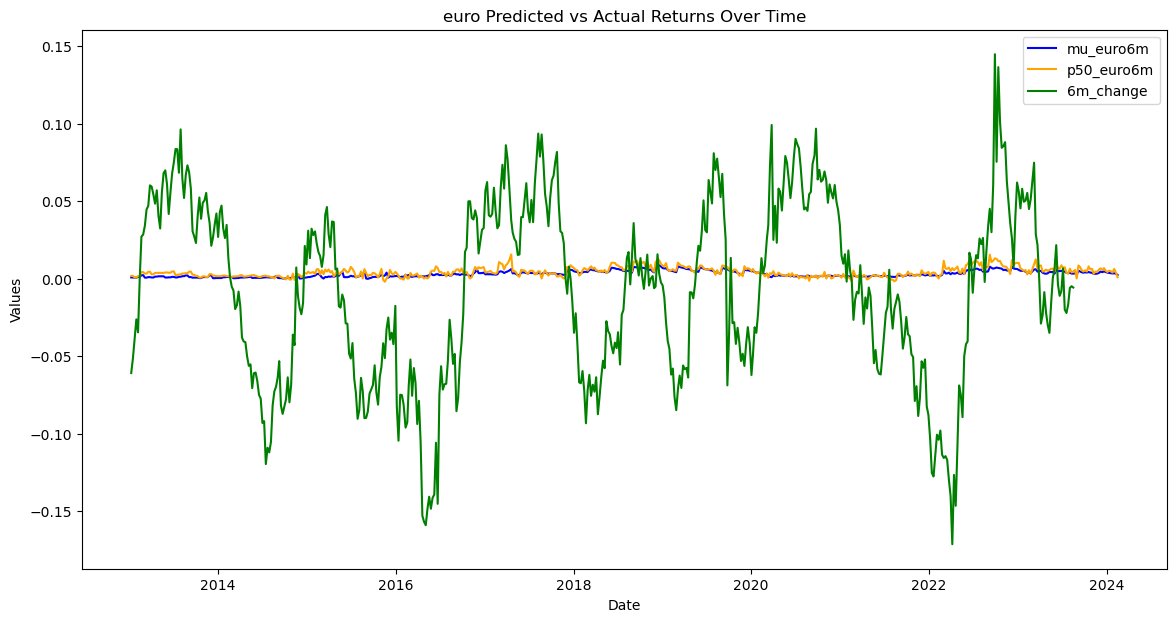

the accuracy of euro predictions {'within_interval_accuracy': 0.5112262521588946, 'above_median_accuracy': 0.43523316062176165, 'total_points': 579}
           Date  6m_return  log_6m_return  log_6m_return_sign
2378 2013-01-10  -0.060968      -0.062905                  -1
2379 2013-01-11  -0.079411      -0.082742                  -1
2380 2013-01-14  -0.072750      -0.075532                  -1
2381 2013-01-15  -0.075615      -0.078627                  -1
2382 2013-01-16  -0.055651      -0.057259                  -1
...         ...        ...            ...                 ...
5142 2023-08-16  -0.005821      -0.005838                  -1
5143 2023-08-17  -0.008455      -0.008491                  -1
5144 2023-08-18  -0.008859      -0.008898                  -1
5145 2023-08-21  -0.008978      -0.009019                  -1
5146 2023-08-22  -0.013334      -0.013423                  -1

[2769 rows x 4 columns]
(0.25087619691183705, 0.4592276936026936, 0.6949068902112681)
(0.00360368750144927

In [28]:
results_calculation(path = 'GBPUSD=X.csv',market='euro',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14')

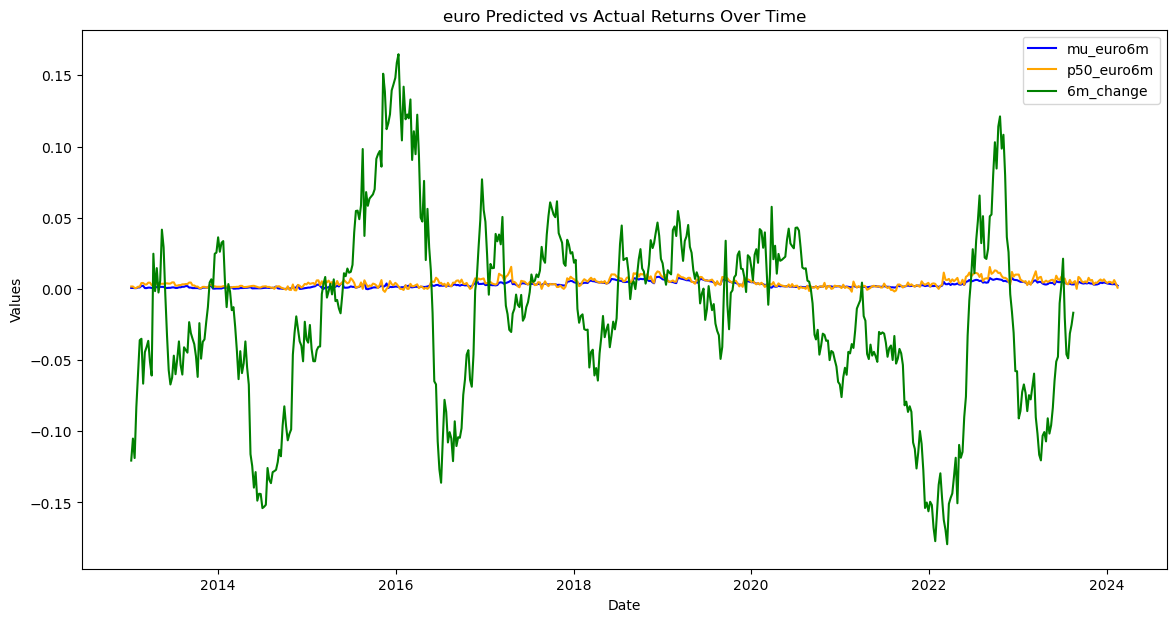

the accuracy of euro predictions {'within_interval_accuracy': 0.5664939550949913, 'above_median_accuracy': 0.37305699481865284, 'total_points': 579}
           Date  6m_return  log_6m_return  log_6m_return_sign
4226 2013-01-10  -0.120571      -0.128483                  -1
4227 2013-01-11  -0.119768      -0.127570                  -1
4228 2013-01-14  -0.112265      -0.119082                  -1
4229 2013-01-15  -0.115584      -0.122828                  -1
4230 2013-01-16  -0.099485      -0.104789                  -1
...         ...        ...            ...                 ...
6990 2023-08-16  -0.016744      -0.016886                  -1
6991 2023-08-17  -0.019608      -0.019803                  -1
6992 2023-08-18  -0.023168      -0.023440                  -1
6993 2023-08-21  -0.027463      -0.027847                  -1
6994 2023-08-22  -0.029687      -0.030137                  -1

[2769 rows x 4 columns]
(0.2481483934850141, 0.4889480064655172, 0.6894413504148185)
(0.03542470199420289,

In [29]:
results_calculation(path = 'JPYUSD=X.csv',market='euro',large_change_threshold=0.1,start_date='2013-01-10',end_date='2024-02-14')